In [1]:
!pip install tensorflow_addons
!pip install keras-tuner --upgrade

# clone minape repository, refresh folder to see the minape repository
# runtime -> change runtime -> choose a gpu/tpu
!git clone https://github.com/hubtru/Minape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00
Cloning into 'Minape'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 3 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 47.82 MiB | 26.83 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa
import keras_tuner

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
#Variables
image_size = 256
in_channel_spec = 9
in_channel_tool = 3
num_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 1
num_epochs = 100

In [42]:
#Functions

#Convert images to numpy array

def read_tools(file_paths, image_size, channels):
  images = []

  for file_path in file_paths:
    img = cv2.imread(file_path)
    res = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    images.append(res)

  images = np.asarray(images, dtype=np.float32)

  # normalize
  images = images / np.max(images)

  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], image_size, image_size, channels)

  return images

def read_specs(file_paths_x, file_paths_y, file_paths_z, image_size, channels):
  images = []

  for i in range(file_paths_x.size):
    img_x = cv2.imread(file_paths_x[i])
    res_x = cv2.resize(img_x, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    images.append(res_x)
    img_y = cv2.imread(file_paths_y[i])
    res_y = cv2.resize(img_y, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    images.append(res_y)
    img_z = cv2.imread(file_paths_z[i])
    res_z = cv2.resize(img_z, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    images.append(res_z)

  images = np.asarray(images, dtype=np.float32)
  images = images / np.max(images)
  images = images.reshape(file_paths_x.shape[0], image_size, image_size, channels)

  return images


#Patch dataset

def generate_datasets(images, labels, is_train=False):
    dataset = images
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto

        )
    return dataset.prefetch(auto)


#Model creation methods
#This method deletes last classification layers from the network, and adds concatenation layer with gru layer
#and new classification layer.
def multimodal_conv_build(model_tool, model_spec):
    inputs1 = model_tool.input
    inputs1._name = "input_tool"
    inputs2 = model_spec.input
    inputs2._name = "input_spec"
    truncated_model_tool = k.Model(inputs = model_tool.input, outputs = model_tool.layers[-2].output)
    truncated_model_spec = k.Model(inputs = model_spec.input, outputs = model_spec.layers[-2].output)
    mergedOut = k.layers.Concatenate()([truncated_model_tool.output, truncated_model_spec.output])
    # reshape = layers.Reshape((1, 1024))(mergedOut) # merged output didn't matched the shape of reshape
    new_dim = truncated_model_tool.output.shape[1] + truncated_model_spec.output.shape[1] # changed
    reshape = layers.Reshape((1, new_dim))(mergedOut)  # changed
    gru = layers.GRU(256, dropout=0.1)(reshape)
    output = layers.Dense(num_classes, activation="softmax", name="output_mult")(gru)
    return k.Model(inputs=[inputs1 ,inputs2], outputs=output)


#Run experiment

def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = k.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )


    history = model.fit(
        dataset_train,
        validation_data=dataset_val,
        epochs=num_epochs,
        shuffle=False,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(dataset_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [6]:
#Dataset acquisition

data_path = '/content/Minape/Data/labels_aug/random_distribution'
train_df = pd.read_csv(f'{data_path}/train.csv', index_col=0)
test_df = pd.read_csv(f'{data_path}/test.csv', index_col=0)
val_df = pd.read_csv(f'{data_path}/val.csv', index_col=0)

tool_path = '/content/Minape/Data/dataset_aug/tool'
train_df['tool'] = train_df.index.map(lambda id: f'{tool_path}/{id}.jpg')
test_df['tool'] = test_df.index.map(lambda id: f'{tool_path}/{id}.jpg')
val_df['tool'] = val_df.index.map(lambda id: f'{tool_path}/{id}.jpg')

spec_path = '/content/Minape/Data/dataset_aug'
train_df['spec_x'] = train_df.index.map(lambda id: f'{spec_path}/specX/{id}.png')
test_df['spec_x'] = test_df.index.map(lambda id: f'{spec_path}/specX/{id}.png')
val_df['spec_x'] = val_df.index.map(lambda id: f'{spec_path}/specX/{id}.png')

train_df['spec_y'] = train_df.index.map(lambda id: f'{spec_path}/specY/{id}.png')
test_df['spec_y'] = test_df.index.map(lambda id: f'{spec_path}/specY/{id}.png')
val_df['spec_y'] = val_df.index.map(lambda id: f'{spec_path}/specY/{id}.png')

train_df['spec_z'] = train_df.index.map(lambda id: f'{spec_path}/specZ/{id}.png')
test_df['spec_z'] = test_df.index.map(lambda id: f'{spec_path}/specZ/{id}.png')
val_df['spec_z'] = val_df.index.map(lambda id: f'{spec_path}/specZ/{id}.png')

In [7]:
#Read tool images and cpectrograms, convert them to NumPy array
x_train_tool = read_tools(train_df.tool.values, image_size, in_channel_tool)
x_test_tool = read_tools(test_df.tool.values, image_size, in_channel_tool)
x_val_tool = read_tools(val_df.tool.values, image_size, in_channel_tool)
x_train_spec = read_specs(train_df.spec_x.values,train_df.spec_y.values,train_df.spec_z.values, image_size, in_channel_spec)
x_test_spec = read_specs(test_df.spec_x.values,test_df.spec_y.values,test_df.spec_z.values, image_size, in_channel_spec)
x_val_spec = read_specs(val_df.spec_x.values,val_df.spec_y.values,val_df.spec_z.values, image_size, in_channel_spec)

#Bring the labels to an acceptable form
labels_train = train_df.tool_label.values - 1
labels_test = test_df.tool_label.values - 1
labels_val = val_df.tool_label.values - 1

labels_train = tf.keras.utils.to_categorical(
    labels_train, num_classes, dtype='float32')
labels_test = tf.keras.utils.to_categorical(
    labels_test, num_classes, dtype='float32')
labels_val = tf.keras.utils.to_categorical(
    labels_val, num_classes, dtype='float32')

In [8]:
#Create tensorflow datasets objects and add patch embedding to train dataset
dataset_train = tf.data.Dataset.from_tensor_slices(({'input_2_tool': x_train_tool, 'input_2_spec': x_train_spec}, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices(({'input_2_tool': x_test_tool, 'input_2_spec': x_test_spec}, labels_test))
dataset_val = tf.data.Dataset.from_tensor_slices(({'input_2_tool': x_val_tool, 'input_2_spec': x_val_spec}, labels_val))

auto = tf.data.AUTOTUNE
inputs1 = k.Input((image_size, image_size, in_channel_tool))
inputs2 = k.Input((image_size, image_size, in_channel_spec))
tool_crop = k.layers.RandomCrop(image_size, image_size)(inputs1)
spec_crop = k.layers.RandomCrop(image_size, image_size)(inputs2)
tool_crop = k.layers.RandomFlip("horizontal")(tool_crop)
spec_crop = k.layers.RandomFlip("horizontal")(spec_crop)

data_augmentation = k.Model(
    inputs={'input_2_tool': inputs1, 'input_2_spec': inputs2},
    outputs={'input_2_tool':tool_crop, 'input_2_spec':spec_crop},
)

dataset_train = generate_datasets(dataset_train, labels_train, is_train=True)
dataset_val = generate_datasets(dataset_val, labels_val)
dataset_test = generate_datasets(dataset_test, labels_test)

In [9]:
#Load inimodal networks and freeze them
model_path = '/content/Minape/models'
model_tool = k.models.load_model(
    f"{model_path}/tool_aug_tool_opt.h5", compile=False)
model_spec = k.models.load_model(
    f"{model_path}/spec_aug_tool_opt.h5", compile=False)

model_spec.trainable = False
model_tool.trainable = False

In [10]:
#Rename layers to divide networks
for layer in model_tool.layers:
    layer._name = layer.name + str('_tool')
for layer in model_spec.layers:
    layer._name = layer.name + str('_spec')

In [43]:
#Build multimodal network
multimodal_conv = multimodal_conv_build(model_tool, model_spec)

In [44]:
#Show summary
multimodal_conv.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2_tool (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1_tool (Rescalin  (None, 256, 256, 3)          0         ['input_2_tool[0][0]']        
 g)                                                                                               
                                                                                                  
 conv2d_9_tool (Conv2D)      (None, 32, 32, 256)          49408     ['rescaling_1_tool[0][0]']    
                                                                                                  
 activation_17_tool (Activa  (None, 32, 32, 256)          0         ['conv2d_9_tool[0][0]']

In [45]:
#Run training
history, model = launch_experiment(multimodal_conv)

Epoch 1/100
15/15 [==============================] - 6s 98ms/step - loss: 0.3385 - accuracy: 0.8667 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 9.5543e-04 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 7/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Ep

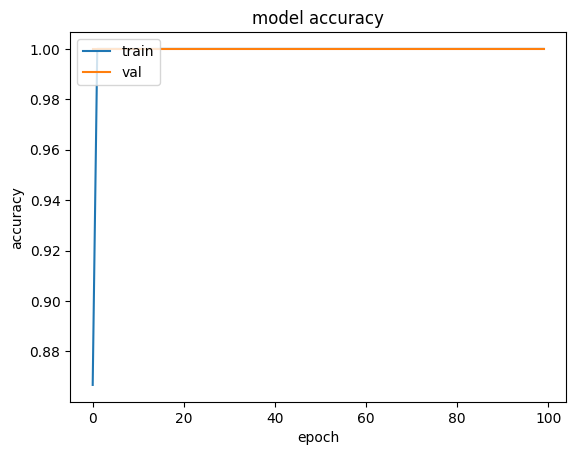

In [46]:
#Plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

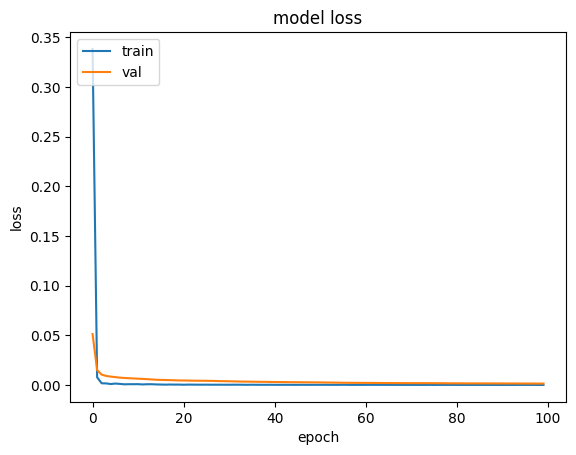

In [47]:
#Plot loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

3/3 [==============================] - 1s 8ms/step


<ipython-input-48-74a66c53d619>:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


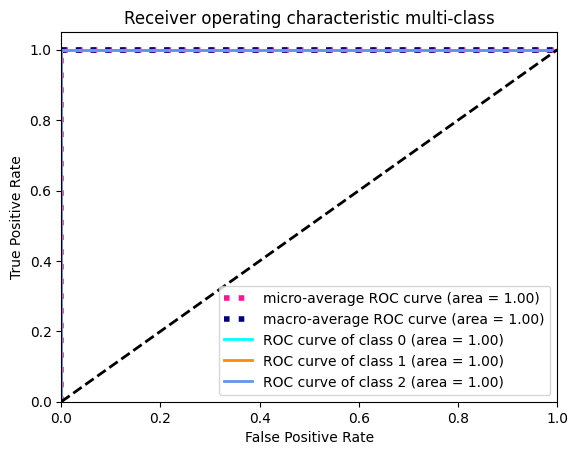

In [48]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
y_score = model.predict(dataset_test)
y_test = labels_test

n_classes = 3
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic multi-class')
plt.legend(loc="lower right")
plt.show()

In [49]:
from sklearn.metrics import classification_report
from sklearn import metrics
y_classes = np.argmax(y_score, axis=1)
labels_test_f1=np.argmax(labels_test, axis=1)
print(metrics.confusion_matrix(labels_test_f1, y_classes))
print(classification_report(labels_test_f1, y_classes))
fpr, tpr, thresholds = metrics.roc_curve(labels_test_f1, y_classes, pos_label=2)
print(metrics.auc(fpr, tpr))

[[1 0 0]
 [0 1 0]
 [0 0 1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

1.0
